In [3]:
import pandas as pd
import os

In [5]:
file_path = '../../../data/metadata/gastrovision.csv'
print(os.path.abspath(file_path))  

C:\Users\mudas\OneDrive\Documents\Desktop\Plaksha\Plaksha-Sem-4\MLPR\Project\GastroCAD\data\metadata\gastrovision.csv


In [7]:
df = pd.read_csv(file_path, header=None)  
df.columns = ["Filename", "Class", "Width", "Height", "Size (kB)"]


In [9]:
df.head()

,Filename,Class,Width,Height,Size (kB)
0,Filename,Class,Width,Height,Size (kB)
1,1a8df39f-4959-42f5-a206-694c40fafb31.jpg,Small bowel_terminal ileum,1920,1072,410.71
2,0f886d51-8576-4208-a850-98aefb696241.jpg,Small bowel_terminal ileum,720,576,168.493
3,142df188-9742-4bce-a38a-792d312c65bf.jpg,Small bowel_terminal ileum,768,576,160.546
4,820228e5-df1a-4bba-a583-a9ca63cae865.jpg,Small bowel_terminal ileum,768,576,295.395


In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Class"])  # Convert text to numbers
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_map)


Label Mapping: {'Accessory tools': 0, 'Angiectasia': 1, "Barrett's esophagus": 2, 'Blood in lumen': 3, 'Cecum': 4, 'Class': 5, 'Colon diverticula': 6, 'Colon polyps': 7, 'Colorectal cancer': 8, 'Duodenal bulb': 9, 'Dyed-lifted-polyps': 10, 'Dyed-resection-margins': 11, 'Erythema': 12, 'Esophageal varices': 13, 'Esophagitis': 14, 'Gastric polyps': 15, 'Gastroesophageal_junction_normal z-line': 16, 'Ileocecal valve': 17, 'Mucosal inflammation large bowel': 18, 'Normal esophagus': 19, 'Normal mucosa and vascular pattern in the large bowel': 20, 'Normal stomach': 21, 'Pylorus': 22, 'Resected polyps': 23, 'Resection margins': 24, 'Retroflex rectum': 25, 'Small bowel_terminal ileum': 26, 'Ulcer': 27}


In [12]:
df.head()

,Filename,Class,Width,Height,Size (kB),Label
0,Filename,Class,Width,Height,Size (kB),5
1,1a8df39f-4959-42f5-a206-694c40fafb31.jpg,Small bowel_terminal ileum,1920,1072,410.71,26
2,0f886d51-8576-4208-a850-98aefb696241.jpg,Small bowel_terminal ileum,720,576,168.493,26
3,142df188-9742-4bce-a38a-792d312c65bf.jpg,Small bowel_terminal ileum,768,576,160.546,26
4,820228e5-df1a-4bba-a583-a9ca63cae865.jpg,Small bowel_terminal ileum,768,576,295.395,26


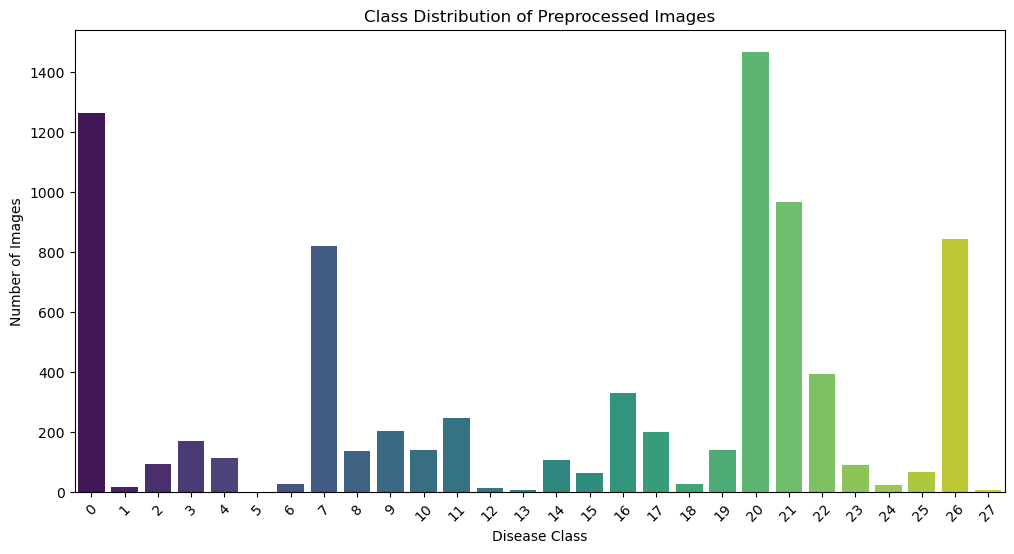

In [20]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
label_counts = Counter(df["Label"])

plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Disease Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution of Preprocessed Images")
plt.show()


In [24]:
import numpy as np

NameError: name 'X' is not defined

In [28]:
import cv2
import numpy as np

def load_and_preprocess_image(filename, class_folder):
    img_path = class_folder + "\\" + filename
    if not os.path.exists(img_path):
        return None  # Skip if file not found
    img = cv2.imread(img_path)  # Load image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (224, 224))  # Resize to 224x224
    img = img / 255.0  # Normalize to [0,1]
    return img
image_data = []
labels = []

for i, row in df.iterrows():
    img_path = f"../../../data/raw/gastrovision/{row['Class']}"
    img_path = os.path.abspath(img_path)
    img = load_and_preprocess_image(row["Filename"], img_path)
    if img is not None:
        image_data.append(img)
        labels.append(row["Label"])

X = np.array(image_data)  # Store images as NumPy array
y = np.array(labels)  # Store labels as array

print("Image Data Shape:", X.shape)  # (num_images, 224, 224, 3)
print("Labels Shape:", y.shape)  # (num_images,)

Image Data Shape: (2453, 224, 224, 3)
Labels Shape: (2453,)


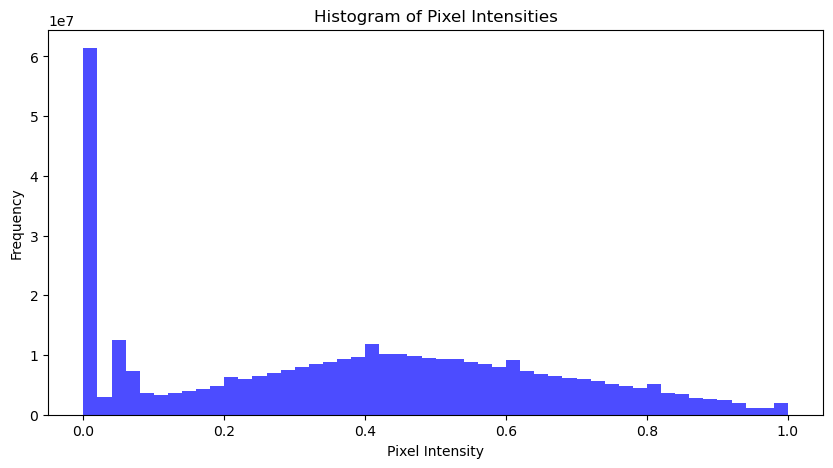

In [30]:
plt.figure(figsize=(10, 5))
plt.hist(X.flatten(), bins=50, color="blue", alpha=0.7)
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Histogram of Pixel Intensities")
plt.show()

In [34]:
import os
import cv2

# Define the processed image directory
processed_dir = "../../../data/processed/gastrovision/"

# Ensure class folders exist
for class_folder in df["Class"].unique():
    os.makedirs(os.path.join(processed_dir, class_folder), exist_ok=True)

# Function to save images
def save_preprocessed_image(img, filename, class_folder):
    save_path = os.path.join(processed_dir, class_folder, filename) + '.jpg'
    img = (img * 255).astype("uint8")  # Convert back to [0,255]
    cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR

# Save images to processed folder
for i, row in df.iterrows():
    save_preprocessed_image(X[i], row["Filename"], row["Class"])
print("Preprocessed images saved successfully!")

IndexError: index 2453 is out of bounds for axis 0 with size 2453